In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [3]:
TARGET_COLUMN = 'statement'
values = df[TARGET_COLUMN].unique().tolist()
values

['Kids are talking by the door', 'Dogs are sitting by the door']

# Dataset preparation

In [4]:
try:
    excluded_prefixes = ['zc']
    columns_to_remove = []
    for column in df[numerical_attr_list].columns:
        if column.startswith(tuple(excluded_prefixes)) or column == TARGET_COLUMN:
            columns_to_remove.append(column)

    columns_to_remove;
    df = df.drop(columns=columns_to_remove, axis=1)
    
except KeyError as e:
    print(e)
    
for col in columns_to_remove:
    try:
        print(col)
        numerical_attr_list.remove(col)
    except ValueError as e:
        print(e, f"raised by column '{col}'")
        

zc_sum
zc_mean
zc_std
zc_kur
zc_skew
zc_mean_w1
zc_sum_w2
zc_skew_w2
zc_sum_w3
zc_kur_w3
zc_sum_w4
zc_mean_w4


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
scaler = MinMaxScaler()
X = scaler.fit_transform(df[numerical_attr_list])

label_enc = LabelEncoder()
y = label_enc.fit_transform(df[TARGET_COLUMN])

# print(f"numerical_attr_list is {numerical_attr_list}")
print(f"target variable: {np.unique(y, return_counts=True)}")
print(f"X has shape {X.shape}")

target variable: (array([0, 1]), array([1216, 1213]))
X has shape (2429, 231)


In [6]:
from sklearn.model_selection import train_test_split

# Divide in train, test, validation
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
test_mask = df.actor_number >= 19
df.drop(columns="actor_number", inplace=True)

X_test, y_test = X[test_mask], y[test_mask]

X_train, X_val, y_train, y_val = train_test_split(X[~test_mask], y[~test_mask], test_size=0.2)
print(f"Train: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}")

Train: (1449, 231)
Val: (363, 231)
Test: (617, 231)


### Default plots

In [7]:
# Shows the decision boundaries in the embedding
def boundaries_on_embedding(reducer, predictor, 
                            embedding=None, n_pts=30, 
                            **kwargs):
    
    global X, y, X_train, X_test,X_val, y_train, y_test, y_val
    cmap, title = kwargs.get("cmap", "viridis"), kwargs.get("title", "Decision boundaries on embedding")
    if embedding is None:
        embedding =  reducer.fit_transform(X)
        
    # Generate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), n_pts)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), n_pts)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    results = predictor.predict(points_in_gigaspace).reshape(old_shape)
    plt.contourf(XX, YY, results.T, cmap=cmap, alpha=0.6, levels=len(np.unique(y))-1)
    plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
    plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    plt.legend()
    plt.axis("off");
    plt.title(title);   

now prepare an  so it saves time

In [8]:
from umap import UMAP
reducer = UMAP(n_neighbors=20)
embedding = reducer.fit_transform(X)

# from sklearn.decomposition import PCA
# reducer = PCA(n_components=2)
# embedding = reducer.fit_transform(X)

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualen

In [9]:
from sklearn.metrics import confusion_matrix

def plot_cfm(y_true, y_pred, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
    cf = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf, annot=True, cmap='Greens', fmt=".4g", cbar=False, ax=ax)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    ticks = np.unique(y_true)
    ax.set_xticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_yticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    
    plt.savefig(f"images/{title.replace(' ', '_')}.pdf")

# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-07-08 15:12:14,706] A new study created in memory with name: no-name-dcbdd95a-477b-4d85-afd6-e15699ec429c
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[W 2023-07-08 15:12:14,721] Trial 3 failed with parameters: {'penalty': 'l1', 'C': 9.712429211543306, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", lin

[W 2023-07-08 15:12:16,326] Trial 10 failed with parameters: {'penalty': 'elasticnet', 'C': 0.23267393100585917, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'non

[W 2023-07-08 15:12:17,642] Trial 20 failed with value None.
[W 2023-07-08 15:12:17,656] Trial 21 failed with parameters: {'penalty': 'elasticnet', 'C': 5.48618766169249, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(ite

[W 2023-07-08 15:12:18,920] Trial 27 failed with value None.
[W 2023-07-08 15:12:18,949] Trial 28 failed with parameters: {'penalty': 'l1', 'C': 2.5181474640966863, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError:

[W 2023-07-08 15:12:19,164] Trial 35 failed with value None.
[W 2023-07-08 15:12:19,184] Trial 36 failed with parameters: {'penalty': 'l1', 'C': 0.1165875790216182, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError:

[I 2023-07-08 15:12:20,345] Trial 44 finished with value: 0.7823691460055097 and parameters: {'penalty': 'l1', 'C': 0.028430233736842503, 'solver': 'saga'}. Best is trial 2 with value: 0.9614325068870524.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[W 2023-07-08 15:12:20,439] Trial 46 failed with parameters: {'penalty': 'elasticnet', 'C': 2.8179915703313627, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/dj

[W 2023-07-08 15:12:20,705] Trial 51 failed with value None.
[W 2023-07-08 15:12:20,748] Trial 54 failed with parameters: {'penalty': 'elasticnet', 'C': 2.8462917202018683, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-08 15:12:20,991] Trial 60 failed with value None.
[W 2023-07-08 15:12:21,000] Trial 61 failed with parameters: {'penalty': 'elasticnet', 'C': 2.65548137114784, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErro

[W 2023-07-08 15:12:21,271] Trial 69 failed with value None.
[W 2023-07-08 15:12:21,270] Trial 68 failed with parameters: {'penalty': 'elasticnet', 'C': 2.6267265136202846, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[I 2023-07-08 15:12:21,576] Trial 45 finished with value: 0.9559228650137741 and parameters: {'penalty': 'l1', 'C': 0.28200853087243194, 'solver': 'saga'}. Best is trial 2 with value: 0.9614325068870524.
[W 2023-07-08 15:12:21,617] Trial 77 failed with parameters: {'penalty': 'elasticnet', 'C': 2.5131216644081023, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.lo

[W 2023-07-08 15:12:21,851] Trial 84 failed with parameters: {'penalty': 'elasticnet', 'C': 2.4498259128916944, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' pena

[W 2023-07-08 15:12:22,051] Trial 91 failed with value None.
[W 2023-07-08 15:12:22,060] Trial 92 failed with parameters: {'penalty': 'elasticnet', 'C': 2.322876346424796, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueErr

[W 2023-07-08 15:12:22,357] Trial 100 failed with parameters: {'penalty': 'elasticnet', 'C': 2.4628529954267884, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' pen

[W 2023-07-08 15:12:22,647] Trial 108 failed with value None.
[W 2023-07-08 15:12:22,531] Trial 106 failed with parameters: {'penalty': 'elasticnet', 'C': 2.5032915515899714, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise Value

[W 2023-07-08 15:12:22,856] Trial 116 failed with value None.
[W 2023-07-08 15:12:22,808] Trial 113 failed with value None.
[W 2023-07-08 15:12:22,848] Trial 115 failed with parameters: {'penalty': 'elasticnet', 'C': 2.0391064749449423, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_

[W 2023-07-08 15:12:23,128] Trial 123 failed with parameters: {'penalty': 'l1', 'C': 2.3676661479639574, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 p

[W 2023-07-08 15:12:23,302] Trial 130 failed with value None.
[W 2023-07-08 15:12:23,312] Trial 131 failed with value None.
[W 2023-07-08 15:12:23,315] Trial 132 failed with parameters: {'penalty': 'elasticnet', 'C': 2.454122308315063, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_m

[W 2023-07-08 15:12:23,517] Trial 138 failed with value None.
[W 2023-07-08 15:12:23,489] Trial 137 failed with value None.
[W 2023-07-08 15:12:23,609] Trial 141 failed with parameters: {'penalty': 'elasticnet', 'C': 2.4322678115854797, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_

[W 2023-07-08 15:12:23,729] Trial 146 failed with value None.
[W 2023-07-08 15:12:23,757] Trial 147 failed with value None.
[W 2023-07-08 15:12:23,771] Trial 149 failed with parameters: {'penalty': 'elasticnet', 'C': 2.32409485311983, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/441388116.py", line 14, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_mo

In [12]:
best_params = study.best_params
logr = LogisticRegression(**best_params)

# Trains on test AND validation
logr.fit(np.concatenate((X_train, X_val)), np.concatenate([y_train, y_val]))

y_pred_test = logr.predict(X_test)

from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


{'penalty': 'none', 'C': 1.1241217317693213, 'solver': 'sag'}
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       309
           1       0.96      0.90      0.93       308

    accuracy                           0.93       617
   macro avg       0.93      0.93      0.93       617
weighted avg       0.93      0.93      0.93       617

Accuracy 0.9303079416531604
F1-score [0.93228346 0.92821369]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

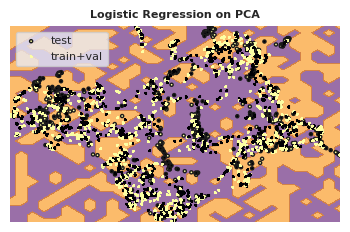

In [62]:
boundaries_on_embedding(reducer, logr, embedding=embedding, 
                        title="Logistic Regression on PCA", 
                        cmap="inferno",
                       n_pts=30)
plt.savefig("images/LogRegUMAP.pdf")

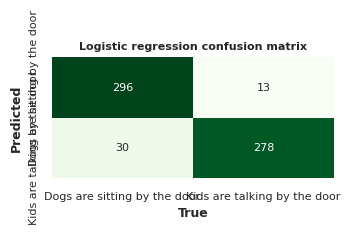

In [14]:
plot_cfm(y_test, y_pred_test, title="Logistic regression confusion matrix")

# Support Vector Machine

## Linear SVM

In [15]:
from sklearn.svm import LinearSVC

In [16]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    
    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_train, y_train)
    
    y_pred = lin_svc.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 15:19:41,254] A new study created in memory with name: no-name-8257fda8-3a57-45b1-aa49-741eb6d5295c
[W 2023-07-08 15:19:41,272] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 98.9866154914385, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local

[W 2023-07-08 15:19:42,118] Trial 11 failed with value None.
[W 2023-07-08 15:19:42,116] Trial 10 failed with parameters: {'penalty': 'l1', 'C': 4.504443161478379, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-08 15:19:44,007] Trial 22 failed with parameters: {'penalty': 'l1', 'C': 0.6052817847240419, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-08 15:19:44,258] Trial 28 failed with parameters: {'penalty': 'l1', 'C': 28.320022970343917, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-07-08 15:19:44,413] Trial 33 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-08 15:19:44,456] Trial 21 finished with value: 0.9586776859504132 and parameters: {'penalty': 'l2', 'C': 55.22990523728413, 'loss': 'squared_hinge'}. Best is trial 17 with value: 0.9614325068870524.
[W 2023-07-08 15:19:44,474] Trial 34 failed with parameters: {'penalty': 'l1', 'C': 26.2884575062636, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(tri

[W 2023-07-08 15:19:44,637] Trial 38 failed with value None.
[W 2023-07-08 15:19:44,634] Trial 41 failed with parameters: {'penalty': 'l1', 'C': 25.046378061142768, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1

[W 2023-07-08 15:19:44,722] Trial 43 failed with value None.
[W 2023-07-08 15:19:44,754] Trial 46 failed with parameters: {'penalty': 'l1', 'C': 28.791645556754272, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1

[W 2023-07-08 15:19:44,880] Trial 50 failed with value None.
[W 2023-07-08 15:19:44,896] Trial 52 failed with parameters: {'penalty': 'l1', 'C': 21.28509704067123, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-07-08 15:19:45,044] Trial 57 failed with value None.
[W 2023-07-08 15:19:45,068] Trial 60 failed with parameters: {'penalty': 'l1', 'C': 29.482657612996544, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1

[W 2023-07-08 15:19:45,159] Trial 63 failed with parameters: {'penalty': 'l1', 'C': 27.582509510334162, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-08 15:19:45,256] Trial 68 failed with value None.
[W 2023-07-08 15:19:45,281] Trial 69 failed with value None.
[W 2023-07-08 15:19:45,318] Trial 71 failed with parameters: {'penalty': 'l1', 'C': 28.68441162210577, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmf

[W 2023-07-08 15:19:45,427] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 25.040174553827775, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-08 15:19:45,543] Trial 80 failed with value None.
[W 2023-07-08 15:19:45,545] Trial 81 failed with value None.
[W 2023-07-08 15:19:45,553] Trial 82 failed with parameters: {'penalty': 'l1', 'C': 22.953669142670417, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRm

[W 2023-07-08 15:19:45,700] Trial 87 failed with value None.
[W 2023-07-08 15:19:45,699] Trial 89 failed with parameters: {'penalty': 'l1', 'C': 25.428074891763526, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1

[W 2023-07-08 15:19:45,839] Trial 95 failed with parameters: {'penalty': 'l1', 'C': 25.70097693421398, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver

[W 2023-07-08 15:19:45,980] Trial 100 failed with parameters: {'penalty': 'l1', 'C': 24.97065738426015, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solve

[W 2023-07-08 15:19:46,085] Trial 106 failed with parameters: {'penalty': 'l1', 'C': 27.756314717125306, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solv

[W 2023-07-08 15:19:46,242] Trial 110 failed with value None.
[W 2023-07-08 15:19:46,246] Trial 112 failed with parameters: {'penalty': 'l1', 'C': 25.449792821953086, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line

[W 2023-07-08 15:19:46,335] Trial 114 failed with value None.
[W 2023-07-08 15:19:46,332] Trial 115 failed with value None.
[W 2023-07-08 15:19:46,345] Trial 117 failed with value None.
[W 2023-07-08 15:19:46,393] Trial 119 failed with parameters: {'penalty': 'l1', 'C': 25.61964397190405, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_libl

[W 2023-07-08 15:19:46,521] Trial 123 failed with value None.
[W 2023-07-08 15:19:46,519] Trial 125 failed with parameters: {'penalty': 'l1', 'C': 23.70189388310608, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

[W 2023-07-08 15:19:46,637] Trial 128 failed with value None.
[W 2023-07-08 15:19:46,638] Trial 130 failed with parameters: {'penalty': 'l1', 'C': 26.543773474844087, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line

[W 2023-07-08 15:19:46,757] Trial 134 failed with value None.
[W 2023-07-08 15:19:46,764] Trial 135 failed with value None.
[W 2023-07-08 15:19:46,766] Trial 136 failed with parameters: {'penalty': 'l1', 'C': 23.062027208286214, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-Peq

[W 2023-07-08 15:19:46,886] Trial 140 failed with value None.
[W 2023-07-08 15:19:46,897] Trial 142 failed with parameters: {'penalty': 'l1', 'C': 29.41680553209393, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

[W 2023-07-08 15:19:47,010] Trial 145 failed with value None.
[W 2023-07-08 15:19:47,038] Trial 148 failed with parameters: {'penalty': 'l1', 'C': 26.42856825078867, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 

In [17]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 3.0975403647375006, 'loss': 'hinge'}
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       309
           1       0.95      0.90      0.92       308

    accuracy                           0.93       617
   macro avg       0.93      0.93      0.93       617
weighted avg       0.93      0.93      0.93       617

Accuracy 0.9270664505672609
F1-score [0.92913386 0.92487479]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


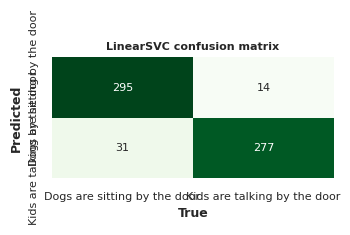

In [18]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', fmt=".4g", cbar=False, ax=ax)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.set_title('LinearSVC confusion matrix')

ticks = np.unique(y)
ax.set_xticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
ax.set_yticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))

plt.savefig("images/LinearSVC_conf_matrix.pdf")

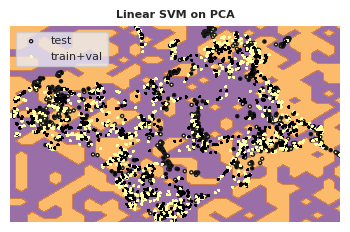

In [19]:
boundaries_on_embedding(reducer, lin_svc, embedding=embedding, 
                        title="Linear SVM on PCA", 
                        cmap="inferno",
                       n_pts=30)

In [20]:
# decision_function = lin_svc.decision_function(X_train)
# support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
# support_vectors = X_train[support_vector_indices]

In [21]:
# # Plots the decision function for diferent values of C
# for i, C in enumerate([0.02, 300]):
#     plt.figure(figsize=default_style.SHORT_HALFSIZE_FIGURE)

#     cmap="viridis"
#     clf = LinearSVC(C=C, loss="hinge", penalty='l2', random_state=42).fit(X_test, y_test)

#     # Genearate a grid in embedding
#     xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), 30)
#     yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), 30)

#     XX, YY = np.meshgrid(xx, yy)
#     points_in_embedding = np.array(np.meshgrid(xx, yy)).T
#     old_shape = points_in_embedding.shape[:-1]
    
#     # Maps them back in the big space
#     points_in_embedding = points_in_embedding.reshape(-1,2)
#     points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

#     # Gets results
#     results = clf.decision_function(points_in_gigaspace)
#     mappable=plt.contourf(XX, YY, results.reshape(old_shape).T, cmap="viridis", alpha=0.6, levels=15)
#     plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
#     plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    
#     # Plot support
#     results = clf.decision_function(X_train)
#     support_vector_indices = np.where((2 * y_train - 1) * results <= 1)[0]
#     plt.scatter(*(embedding[~test_mask][support_vector_indices]).T, s=10, color="r")
#     plt.axis("off")
# #     decision_function = clf.decision_function(X_res_t)
# # #     we can also calculate the decision function manually
# # #     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
# #     support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# #     support_vectors = X_res_t[support_vector_indices]
# #     support_vectors_pca = pca.transform(support_vectors)

# #     plt.subplot(1, 2, i + 1)
# #     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
# #     ax = plt.gca()
# #     xlim = ax.get_xlim()
# #     ylim = ax.get_ylim()
# #     xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
# #                          np.linspace(ylim[0], ylim[1], 50))
# #     clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
# #     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# #     Z = Z.reshape(xx.shape)
# #     plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
# #                 linestyles=['--', '-', '--'])
# #     plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
# #                 linewidth=1, facecolors='none', edgecolors='k')
# #     plt.title("C=" + str(C))
# #     #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
# # plt.tight_layout()
# # plt.show()
#     plt.savefig(f"images/linear_svm_UMAP_decision_function_C_{C}.pdf")
#     plt.colorbar(mappable)

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [22]:
from sklearn.svm import SVC

In [23]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.1,80)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_train, y_train)
    y_pred = lin_svc.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 250, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 15:20:50,505] A new study created in memory with name: no-name-7575583a-d439-424f-a08d-40eac4d4f648
[I 2023-07-08 15:20:50,750] Trial 3 finished with value: 0.9586776859504132 and parameters: {'kernel': 'poly', 'C': 31.009873512017172, 'gamma': 0.7506084665277776}. Best is trial 3 with value: 0.9586776859504132.
[I 2023-07-08 15:20:50,983] Trial 4 finished with value: 0.9586776859504132 and parameters: {'kernel': 'poly', 'C': 71.0818997182604, 'gamma': 0.7548534330191142}. Best is trial 3 with value: 0.9586776859504132.
[I 2023-07-08 15:20:51,284] Trial 5 finished with value: 0.9586776859504132 and parameters: {'kernel': 'poly', 'C': 73.48830166188019, 'gamma': 0.8219833601934208}. Best is trial 3 with value: 0.9586776859504132.
[I 2023-07-08 15:20:51,313] Trial 2 finished with value: 0.4820936639118457 and parameters: {'kernel': 'sigmoid', 'C': 3.7294243432104377, 'gamma': 0.6464274955883247}. Best is trial 3 with value: 0.9586776859504132.
[I 2023-07-08 15:20:51,334] Tr

[I 2023-07-08 15:20:56,544] Trial 38 finished with value: 0.4820936639118457 and parameters: {'kernel': 'sigmoid', 'C': 64.22934434790488, 'gamma': 0.18733035646400992}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:20:56,609] Trial 39 finished with value: 0.4820936639118457 and parameters: {'kernel': 'sigmoid', 'C': 59.56627177869247, 'gamma': 0.16675841813134212}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:20:56,630] Trial 40 finished with value: 0.5234159779614325 and parameters: {'kernel': 'sigmoid', 'C': 59.08957149370967, 'gamma': 0.07711555035026654}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:20:56,942] Trial 42 finished with value: 0.9614325068870524 and parameters: {'kernel': 'rbf', 'C': 74.5187715222135, 'gamma': 0.07986562203695109}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:20:56,950] Trial 41 finished with value: 0.4820936639118457 and parameters: {'kernel': 'sigmoid', 'C': 73.640756

[I 2023-07-08 15:21:01,668] Trial 75 finished with value: 0.9586776859504132 and parameters: {'kernel': 'rbf', 'C': 72.19057813432454, 'gamma': 0.23351079392627996}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:01,689] Trial 78 finished with value: 0.9752066115702479 and parameters: {'kernel': 'rbf', 'C': 64.7106005757501, 'gamma': 0.026184287663825117}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:01,966] Trial 79 finished with value: 0.9696969696969697 and parameters: {'kernel': 'rbf', 'C': 64.09091665396505, 'gamma': 0.18336282821075992}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:02,034] Trial 82 finished with value: 0.9696969696969697 and parameters: {'kernel': 'rbf', 'C': 67.69095407960538, 'gamma': 0.03027870399658164}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:02,066] Trial 81 finished with value: 0.9641873278236914 and parameters: {'kernel': 'rbf', 'C': 64.60905996125996, 'gamm

[I 2023-07-08 15:21:05,762] Trial 114 finished with value: 0.9586776859504132 and parameters: {'kernel': 'rbf', 'C': 74.59111961091966, 'gamma': 0.0013792371688843529}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:05,836] Trial 116 finished with value: 0.9586776859504132 and parameters: {'kernel': 'rbf', 'C': 70.84838893782546, 'gamma': 0.0011452488792927616}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:06,036] Trial 118 finished with value: 0.9834710743801653 and parameters: {'kernel': 'rbf', 'C': 77.5399036533778, 'gamma': 0.019122726088211594}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:06,121] Trial 117 finished with value: 0.953168044077135 and parameters: {'kernel': 'rbf', 'C': 75.50851495226027, 'gamma': 0.0016193518038298133}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:06,172] Trial 120 finished with value: 0.9696969696969697 and parameters: {'kernel': 'rbf', 'C': 77.96388502071

[I 2023-07-08 15:21:09,481] Trial 153 finished with value: 0.9614325068870524 and parameters: {'kernel': 'rbf', 'C': 68.1064788616774, 'gamma': 0.08832116219644745}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:09,510] Trial 154 finished with value: 0.9614325068870524 and parameters: {'kernel': 'rbf', 'C': 78.02620828436902, 'gamma': 0.07896902052712208}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:09,512] Trial 155 finished with value: 0.9586776859504132 and parameters: {'kernel': 'rbf', 'C': 77.98341142424891, 'gamma': 0.08427651390833363}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:09,747] Trial 156 finished with value: 0.977961432506887 and parameters: {'kernel': 'rbf', 'C': 77.98646355269969, 'gamma': 0.02114736545540879}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:09,886] Trial 159 finished with value: 0.9752066115702479 and parameters: {'kernel': 'rbf', 'C': 76.71829939489636, 'g

[I 2023-07-08 15:21:13,906] Trial 189 finished with value: 0.9641873278236914 and parameters: {'kernel': 'rbf', 'C': 73.38780621188077, 'gamma': 0.04682023987816558}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:14,123] Trial 192 finished with value: 0.9641873278236914 and parameters: {'kernel': 'rbf', 'C': 68.38325949309245, 'gamma': 0.04864022988344041}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:14,311] Trial 193 finished with value: 0.9641873278236914 and parameters: {'kernel': 'rbf', 'C': 69.11574668950114, 'gamma': 0.04606588465779945}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:14,324] Trial 195 finished with value: 0.9752066115702479 and parameters: {'kernel': 'rbf', 'C': 44.4992773859216, 'gamma': 0.03579769657130323}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:14,424] Trial 196 finished with value: 0.977961432506887 and parameters: {'kernel': 'rbf', 'C': 71.16784499687992, 'g

[I 2023-07-08 15:21:18,719] Trial 230 finished with value: 0.9641873278236914 and parameters: {'kernel': 'rbf', 'C': 74.69416539341866, 'gamma': 0.05800429448505815}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:18,778] Trial 227 finished with value: 0.928374655647383 and parameters: {'kernel': 'rbf', 'C': 74.1705406632496, 'gamma': 0.6485695325580833}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:19,041] Trial 233 finished with value: 0.9807162534435262 and parameters: {'kernel': 'poly', 'C': 53.28701428671427, 'gamma': 0.020321237356688886}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:19,098] Trial 232 finished with value: 0.977961432506887 and parameters: {'kernel': 'rbf', 'C': 76.40051646136182, 'gamma': 0.020773485898699352}. Best is trial 34 with value: 0.9834710743801653.
[I 2023-07-08 15:21:19,110] Trial 234 finished with value: 0.9752066115702479 and parameters: {'kernel': 'rbf', 'C': 55.83064507412496, '

In [24]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(np.concatenate((X_train, X_val)),np.concatenate((y_train, y_val)))

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'rbf', 'C': 65.82867332256988, 'gamma': 0.020405532222576565}
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       309
           1       0.95      0.92      0.94       308

    accuracy                           0.94       617
   macro avg       0.94      0.94      0.94       617
weighted avg       0.94      0.94      0.94       617

Accuracy 0.9384116693679092
F1-score [0.93949045 0.93729373]


In [25]:
print(svc.support_vectors_.shape)
print(X.shape)

(300, 231)
(2429, 231)


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


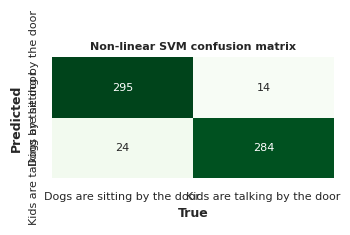

In [26]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g", ax=ax)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Non-linear SVM confusion matrix')

ax.set_xticks([0.5,1.5], labels=label_enc.inverse_transform([[0],[1]]))
ax.set_yticks([0.5,1.5], labels=label_enc.inverse_transform([[0],[1]]))

plt.savefig("images/nonlinear_svm_conf_matrix.pdf")
plt.show()

In [27]:
# support_vectors_pca = pca.transform(svc.support_vectors_)

In [28]:
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
#             cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=10)
# plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=10,
#                 linewidth=1, facecolors='none', edgecolors='k')
# plt.show()

In [29]:
# decision_function = svc.decision_function(X_res_t)
# support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# support_vectors = X_res_t[support_vector_indices]

In [30]:
# support_vectors_pca = pca.transform(support_vectors)

In [31]:
# for kernel in ('linear', 'rbf', 'poly'):
#     clf = SVC(kernel=kernel, gamma=0.1, C=26)
#     clf.fit(X_res_t, y_res_t)

#     plt.figure()
#     plt.clf()
#     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, zorder=10, cmap=plt.cm.Paired,
#                 edgecolor='k', s=20)

#     # Circle out the test data
# #     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
# #                 zorder=10, edgecolor='k')

#     plt.axis('tight')
#     x_min = X_pca[:, 0].min()
#     x_max = X_pca[:, 0].max()
#     y_min = X_pca[:, 1].min()
#     y_max = X_pca[:, 1].max()

#     XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
#     clf.fit(X_pca, y_res_t)
#     Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(XX.shape)
#     plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
#     plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
#                 linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

#     plt.title(kernel)
# plt.show()

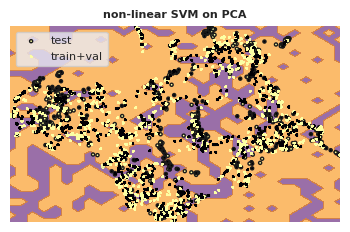

In [32]:
boundaries_on_embedding(reducer, svc, embedding=embedding, 
                        title="non-linear SVM on PCA", 
                        cmap="inferno",
                        n_pts=30)
# plt.scatter(*(reducer.transform(svc.support_vectors_).T), color="r", s=10 , marker="+")

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [33]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [34]:
from scikeras.wrappers import KerasClassifier

In [35]:
from sklearn.model_selection import RandomizedSearchCV

In [36]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [37]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [38]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    
    net.fit(X_train, y_train, epochs=50)
    y_pred = net.predict(X_val).astype(int)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 15:22:23,133] A new study created in memory with name: no-name-2a2b1a6b-ec20-42b0-885e-6028458092b0
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10) wh

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
46/46 [==============================] - 4s 12ms/step - loss: 0.6999 - accuracy: 0.5052
Epoch 2/50
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6605 - accuracy: 0.6315
Epoch 3/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6935 - accuracy: 0.5052
Epoch 3/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6145 - accuracy: 0.6825
Epoch 4/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6926 - accuracy: 0.5100
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4654 - accuracy: 0.8150
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4593 - accuracy: 0.8226
Epoch 4/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5084 - accuracy: 0.7502
Epoch 9/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4795 - accuracy: 0.7805
Epoch 9/50
46/46 [==============================] - 0s 10ms/step - 

46/46 [==============================] - 0s 9ms/step - loss: 0.1706 - accuracy: 0.9296
Epoch 12/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3065 - accuracy: 0.8868
Epoch 17/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1422 - accuracy: 0.9517
Epoch 13/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3594 - accuracy: 0.8295
Epoch 18/50
Epoch 18/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.5176
Epoch 18/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1189 - accuracy: 0.9572
Epoch 14/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2794 - accuracy: 0.8896
Epoch 19/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5121
Epoch 19/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3520 - accuracy: 0.8316
Epoch 20/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6925 - accuracy: 0.5052
Epoch 20

46/46 [==============================] - 0s 10ms/step - loss: 0.1819 - accuracy: 0.9441
Epoch 32/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2567 - accuracy: 0.8930
Epoch 33/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0655 - accuracy: 0.9786
Epoch 28/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2140 - accuracy: 0.9206
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2704 - accuracy: 0.8847
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2029 - accuracy: 0.9199
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1849 - accuracy: 0.9303
Epoch 36/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0655 - accuracy: 0.9752
Epoch 38/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6922 - accuracy: 0.5259
Epoch 38/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.5155
Epoch 39/50
Epoc

46/46 [==============================] - 0s 10ms/step - loss: 0.0580 - accuracy: 0.9800
Epoch 40/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1591 - accuracy: 0.9372
Epoch 45/50
Epoch 45/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.5238
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0635 - accuracy: 0.9786
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0519 - accuracy: 0.9848
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1883 - accuracy: 0.9227
Epoch 48/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1391 - accuracy: 0.9496
Epoch 49/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6919 - accuracy: 0.5121
Epoch 49/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1362 - accuracy: 0.9545
Epoch 50/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0653 - accuracy: 0.9752
Epo

[I 2023-07-08 15:22:50,652] Trial 2 finished with value: 0.4820936639118457 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 2 with value: 0.4820936639118457.


27/46 [================>.............] - ETA: 0s - loss: 0.0470 - accuracy: 0.9873

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 7ms/step - loss: 0.0510 - accuracy: 0.9841
Epoch 48/50
 1/46 [..............................] - ETA: 0s - loss: 0.3399 - accuracy: 0.9062

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)


43/46 [===========================>..] - ETA: 0s - loss: 0.0476 - accuracy: 0.9847Epoch 1/50
Epoch 1/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0493 - accuracy: 0.9841
Epoch 49/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0686 - accuracy: 0.9779
Epoch 50/50
12/12 [==============================] - 0s 6ms/step


[I 2023-07-08 15:22:52,399] Trial 0 finished with value: 0.9366391184573003 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9366391184573003.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

Epoch 1/50
46/46 [==============================] - 3s 8ms/step - loss: 0.6883 - accuracy: 0.5238
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6755 - accuracy: 0.5983
Epoch 3/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6654 - accuracy: 0.6190
Epoch 4/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6516 - accuracy: 0.6756
Epoch 5/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6329 - accuracy: 0.7095
Epoch 6/50
46/46 [==============================] - 4s 8ms/step - loss: 0.6661 - accuracy: 0.5956
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6165 - accuracy: 0.7274
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.5583 - accuracy: 0.7681
Epoch 3/50
46/46 [==============================] - 0s 6ms/step - loss: 0.3650 - accuracy: 0.8854
Epoch 4/50
46/46 [==============================] - 0s 6ms/step - loss: 0.5716 - accuracy: 0.7819
Epoch 9/50
46/46 [==

46/46 [==============================] - 0s 7ms/step - loss: 0.0929 - accuracy: 0.9689
Epoch 24/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1214 - accuracy: 0.9545
Epoch 20/50
46/46 [==============================] - 0s 6ms/step - loss: 0.2738 - accuracy: 0.8792
Epoch 30/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1010 - accuracy: 0.9641
Epoch 25/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1157 - accuracy: 0.9579
Epoch 21/50
46/46 [==============================] - 0s 7ms/step - loss: 0.2259 - accuracy: 0.9137
Epoch 31/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0801 - accuracy: 0.9696
Epoch 26/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.9531
Epoch 22/50
46/46 [==============================] - 0s 6ms/step - loss: 0.2821 - accuracy: 0.8847
Epoch 32/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0911 - accuracy: 0.9614
Epoch 27/50
46/46 [===

[I 2023-07-08 15:23:08,653] Trial 1 finished with value: 0.9035812672176309 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9366391184573003.


33/46 [====================>.........] - ETA: 0s - loss: 0.0614 - accuracy: 0.9763

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.1453 - accuracy: 0.9489
Epoch 49/50
 7/46 [===>..........................] - ETA: 0s - loss: 0.2279 - accuracy: 0.8973Epoch 40/50
Epoch 44/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2993 - accuracy: 0.8772
Epoch 50/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0861 - accuracy: 0.9676
Epoch 45/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0976 - accuracy: 0.9634
Epoch 42/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0590 - accuracy: 0.9800
Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1278 - accuracy: 0.9469
Epoch 43/50
13/46 [=======>......................] - ETA: 0s - loss: 0.0442 - accuracy: 0.9856

[I 2023-07-08 15:23:11,033] Trial 4 finished with value: 0.8980716253443526 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9366391184573003.


28/46 [=================>............] - ETA: 0s - loss: 0.0530 - accuracy: 0.9833

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.0653 - accuracy: 0.9772
Epoch 48/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1097 - accuracy: 0.9524
Epoch 45/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0893 - accuracy: 0.9620
Epoch 49/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0839 - accuracy: 0.9710
Epoch 46/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0795 - accuracy: 0.9696
Epoch 50/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1262 - accuracy: 0.9524
Epoch 47/50
46/46 [==============================] - 4s 10ms/step - loss: 0.6943 - accuracy: 0.5273
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0745 - accuracy: 0.9758
Epoch 48/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6814 - accuracy: 0.5990
Epoch 3/50
20/46 [============>.................] - ETA: 0s - loss: 0.6737 - accuracy: 0.6062

[I 2023-07-08 15:23:13,606] Trial 5 finished with value: 0.9641873278236914 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9641873278236914.


 7/46 [===>..........................] - ETA: 0s - loss: 0.0384 - accuracy: 0.9955

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 11ms/step - loss: 0.0694 - accuracy: 0.9758
Epoch 50/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6636 - accuracy: 0.6549
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6552 - accuracy: 0.6536
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6415 - accuracy: 0.6936
Epoch 7/50


[I 2023-07-08 15:23:15,439] Trial 6 finished with value: 0.9614325068870524 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9641873278236914.


10/46 [=====>........................] - ETA: 0s - loss: 0.6376 - accuracy: 0.6344

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.6322 - accuracy: 0.6957
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6131 - accuracy: 0.7350
Epoch 9/50
46/46 [==============================] - 5s 8ms/step - loss: 0.7619 - accuracy: 0.5052
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5701 - accuracy: 0.7798
Epoch 11/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.5052
Epoch 4/50
46/46 [==============================] - 0s 11ms/step - loss: 0.5428 - accuracy: 0.7930
Epoch 5/50
Epoch 12/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5093
Epoch 13/50
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6935 - accuracy: 0.4934
Epoch 7/50
46/46 [==============================] - 1s 11ms/step - loss: 0.4756 - accuracy: 0.8261
Epoch 14/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5052


46/46 [==============================] - 0s 10ms/step - loss: 0.2860 - accuracy: 0.8778
Epoch 13/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1276 - accuracy: 0.9517
Epoch 29/50
Epoch 14/50
Epoch 15/50
46/46 [==============================] - 0s 8ms/step - loss: 0.3826 - accuracy: 0.9130
Epoch 23/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.4997
Epoch 16/50
46/46 [==============================] - 0s 11ms/step - loss: 0.2670 - accuracy: 0.8889
Epoch 31/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6935 - accuracy: 0.4886
Epoch 18/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2500 - accuracy: 0.9117
Epoch 32/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2952 - accuracy: 0.9255
Epoch 26/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6934 - accuracy: 0.5052
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0877 - accuracy: 

46/46 [==============================] - 0s 11ms/step - loss: 0.1781 - accuracy: 0.9351
Epoch 42/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1707 - accuracy: 0.9551
Epoch 37/50
28/46 [=================>............] - ETA: 0s - loss: 0.6935 - accuracy: 0.4955Epoch 39/50
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.4997
Epoch 32/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1992 - accuracy: 0.9186
Epoch 45/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1177 - accuracy: 0.9524
Epoch 30/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0752 - accuracy: 0.9696
Epoch 31/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6933 - accuracy: 0.5052
Epoch 34/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0676 - accuracy: 0.9745
Epoch 32/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1486 - accuracy: 0.9545
Epoch 42/5

[I 2023-07-08 15:23:36,906] Trial 7 finished with value: 0.9504132231404959 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9641873278236914.


46/46 [==============================] - 1s 11ms/step - loss: 0.6933 - accuracy: 0.5045
Epoch 40/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0985 - accuracy: 0.9609

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.1340 - accuracy: 0.9593
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.5079
Epoch 41/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1383 - accuracy: 0.9579
Epoch 49/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6933 - accuracy: 0.5045
Epoch 42/50
16/46 [=========>....................] - ETA: 0s - loss: 0.0464 - accuracy: 0.9766

[I 2023-07-08 15:23:39,673] Trial 8 finished with value: 0.9449035812672176 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9641873278236914.


46/46 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5066


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0767 - accuracy: 0.9689
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1043 - accuracy: 0.9565
Epoch 44/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6932 - accuracy: 0.5052
Epoch 49/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5114
Epoch 50/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1034 - accuracy: 0.9551
Epoch 47/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0632 - accuracy: 0.9738
Epoch 48/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0578 - accuracy: 0.9758
Epoch 49/50
32/46 [===================>..........] - ETA: 0s - loss: 0.0449 - accuracy: 0.9824

[I 2023-07-08 15:23:43,146] Trial 10 finished with value: 0.4820936639118457 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9641873278236914.


46/46 [==============================] - 3s 7ms/step - loss: 0.7220 - accuracy: 0.4948
Epoch 2/50
46/46 [==============================] - 6s 8ms/step - loss: 0.6931 - accuracy: 0.5169


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.0742 - accuracy: 0.9738
Epoch 1/50
 6/46 [==>...........................] - ETA: 0s - loss: 0.4881 - accuracy: 0.8385

[I 2023-07-08 15:23:44,467] Trial 9 finished with value: 0.9614325068870524 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9641873278236914.


29/46 [=================>............] - ETA: 0s - loss: 0.4510 - accuracy: 0.8578

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.6924 - accuracy: 0.5114
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4364 - accuracy: 0.8468
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6924 - accuracy: 0.5238
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3212 - accuracy: 0.8854
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.5321
Epoch 7/50
46/46 [==============================] - 0s 11ms/step - loss: 0.2878 - accuracy: 0.8847
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5328
Epoch 8/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6922 - accuracy: 0.5238
Epoch 10/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5349
Epoch 11/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6923 - accuracy: 0.5224
Epoch 12/50
46/46 [===

46/46 [==============================] - 0s 9ms/step - loss: 0.2266 - accuracy: 0.9220
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1337 - accuracy: 0.9538
Epoch 11/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1018 - accuracy: 0.9627
Epoch 27/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1287 - accuracy: 0.9572
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1865 - accuracy: 0.9406
Epoch 12/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1056 - accuracy: 0.9614
Epoch 15/50
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1750 - accuracy: 0.9420
Epoch 31/50
Epoch 14/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1038 - accuracy: 0.9627
Epoch 30/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1264 - accuracy: 0.9489
Epoch 16/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1622 - accuracy: 

Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1144 - accuracy: 0.9600
Epoch 27/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0714 - accuracy: 0.9793
Epoch 28/50
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6903 - accuracy: 0.5252
Epoch 45/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1669 - accuracy: 0.9331
Epoch 29/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0698 - accuracy: 0.9786
Epoch 46/50
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1256 - accuracy: 0.9600
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0642 - accuracy: 0.9765
Epoch 47/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0594 - accuracy: 0.9793
Epoch 33/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0739 - accuracy: 0.9689
Epoch 34/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0804

[I 2023-07-08 15:24:06,074] Trial 12 finished with value: 0.628099173553719 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9641873278236914.


16/46 [=========>....................] - ETA: 0s - loss: 0.0506 - accuracy: 0.9863

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 11ms/step - loss: 0.0552 - accuracy: 0.9848
Epoch 37/50
24/46 [==============>...............] - ETA: 0s - loss: 0.0625 - accuracy: 0.9766

[I 2023-07-08 15:24:06,875] Trial 11 finished with value: 0.9421487603305785 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9641873278236914.


46/46 [==============================] - 1s 11ms/step - loss: 0.1117 - accuracy: 0.9607
Epoch 37/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0877 - accuracy: 0.9661

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.0601 - accuracy: 0.9779
Epoch 38/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0653 - accuracy: 0.9786
Epoch 39/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0763 - accuracy: 0.9703
Epoch 41/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0932 - accuracy: 0.9731
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0955 - accuracy: 0.9593
Epoch 42/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1045 - accuracy: 0.9648
Epoch 42/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0665 - accuracy: 0.9731
Epoch 43/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1167 - accuracy: 0.9538
Epoch 43/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0627 - accuracy: 0.9738
Epoch 44/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0935 - accuracy: 0.9703
Epoch 44/50
46/

[I 2023-07-08 15:24:13,948] Trial 13 finished with value: 0.9669421487603306 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 13 with value: 0.9669421487603306.


25/46 [===============>..............] - ETA: 0s - loss: 0.5897 - accuracy: 0.8087

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

16/46 [=========>....................] - ETA: 0s - loss: 0.6855 - accuracy: 0.5547

[I 2023-07-08 15:24:14,184] Trial 14 finished with value: 0.9504132231404959 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 13 with value: 0.9669421487603306.


37/46 [=======================>......] - ETA: 0s - loss: 0.6797 - accuracy: 0.5667

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.5798 - accuracy: 0.7937
Epoch 4/50
46/46 [==============================] - 8s 10ms/step - loss: 0.6751 - accuracy: 0.5797
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5039 - accuracy: 0.8489
Epoch 1/50
Epoch 5/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5648 - accuracy: 0.7867
Epoch 4/50
46/46 [==============================] - 0s 11ms/step - loss: 0.3592 - accuracy: 0.8730
Epoch 7/50
46/46 [==============================] - 1s 12ms/step - loss: 0.2981 - accuracy: 0.9124
Epoch 8/50
46/46 [==============================] - 1s 11ms/step - loss: 0.3464 - accuracy: 0.8896
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2552 - accuracy: 0.9234
Epoch 9/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2745 - accuracy: 0.9020
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2334 - accuracy: 0.9234
Epoch 10/50
46

46/46 [==============================] - 0s 10ms/step - loss: 0.1487 - accuracy: 0.9441
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1524 - accuracy: 0.9406
Epoch 11/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1473 - accuracy: 0.9482
Epoch 12/50
Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1142 - accuracy: 0.9614
Epoch 26/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1246 - accuracy: 0.9558
Epoch 13/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1315 - accuracy: 0.9503
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1172 - accuracy: 0.9586
Epoch 15/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0962 - accuracy: 0.9689
Epoch 29/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1348 - accuracy: 0.9434
Epoch 16/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1035 - accuracy: 0.9627
E

46/46 [==============================] - 0s 10ms/step - loss: 0.1060 - accuracy: 0.9607
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0854 - accuracy: 0.9689
Epoch 25/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0855 - accuracy: 0.9662
Epoch 26/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1011 - accuracy: 0.9634
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0940 - accuracy: 0.9614
Epoch 40/50
Epoch 27/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1431 - accuracy: 0.9393
Epoch 27/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0726 - accuracy: 0.9766Epoch 43/50
Epoch 30/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1025 - accuracy: 0.9620
Epoch 47/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0885 - accuracy: 0.9703
Epoch 44/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0801 - accuracy: 0.9

[I 2023-07-08 15:24:37,119] Trial 16 finished with value: 0.9476584022038568 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 13 with value: 0.9669421487603306.


21/46 [============>.................] - ETA: 0s - loss: 0.0673 - accuracy: 0.9747

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.0706 - accuracy: 0.9717
Epoch 50/50
12/12 [==============================] - 0s 9ms/step
Epoch 39/50
22/46 [=============>................] - ETA: 0s - loss: 0.0341 - accuracy: 0.9872

[I 2023-07-08 15:24:38,931] Trial 15 finished with value: 0.9366391184573003 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 13 with value: 0.9669421487603306.


46/46 [==============================] - 0s 9ms/step - loss: 0.0739 - accuracy: 0.9703
Epoch 40/50
44/46 [===========================>..] - ETA: 0s - loss: 0.0597 - accuracy: 0.9773

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.0723 - accuracy: 0.9731
Epoch 41/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0932 - accuracy: 0.9634
Epoch 41/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0957 - accuracy: 0.9669
Epoch 42/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0959 - accuracy: 0.9565
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0527 - accuracy: 0.9841
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0611 - accuracy: 0.9772
Epoch 44/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0500 - accuracy: 0.9814
Epoch 45/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0394 - accuracy: 0.9896
Epoch 45/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0365 - accuracy: 0.9896
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0578 - accuracy: 0.9793
Epoch 47/50


[I 2023-07-08 15:24:45,037] Trial 17 finished with value: 0.9614325068870524 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 13 with value: 0.9669421487603306.


46/46 [==============================] - 0s 5ms/step - loss: 0.2990 - accuracy: 0.8778
Epoch 5/50
42/46 [==========================>...] - ETA: 0s - loss: 0.6812 - accuracy: 0.5528

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 7ms/step - loss: 0.2176 - accuracy: 0.9220
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6138 - accuracy: 0.6729
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1982 - accuracy: 0.9248
Epoch 7/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4680 - accuracy: 0.8116
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.3504 - accuracy: 0.8544
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1522 - accuracy: 0.9489
Epoch 9/50
46/46 [==============================] - 0s 8ms/step - loss: 0.2280 - accuracy: 0.9130
Epoch 7/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1355 - accuracy: 0.9517
Epoch 11/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9420
Epoch 12/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1733 - accuracy: 0.9420
Epoch 9/50
46/46 [===========

46/46 [==============================] - 0s 8ms/step - loss: 0.1138 - accuracy: 0.9586
Epoch 16/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0764 - accuracy: 0.9765
Epoch 29/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0851 - accuracy: 0.9689
Epoch 33/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1436 - accuracy: 0.9406
Epoch 30/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0707 - accuracy: 0.9738
Epoch 34/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1056 - accuracy: 0.9620
Epoch 18/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1009 - accuracy: 0.9565
Epoch 31/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1072 - accuracy: 0.9531
Epoch 35/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0861 - accuracy: 0.9676
Epoch 32/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1145 - accuracy: 0.9600
Epoch 20/50
46/46 [===

[I 2023-07-08 15:25:01,316] Trial 19 finished with value: 0.9641873278236914 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 13 with value: 0.9669421487603306.


46/46 [==============================] - 0s 7ms/step - loss: 0.0833 - accuracy: 0.9710
Epoch 50/50
37/46 [=======================>......] - ETA: 0s - loss: 0.0756 - accuracy: 0.9738

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.0729 - accuracy: 0.9745
Epoch 37/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0773 - accuracy: 0.9717
Epoch 38/50
14/46 [========>.....................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9732

[I 2023-07-08 15:25:02,280] Trial 18 finished with value: 0.9724517906336089 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


29/46 [=================>............] - ETA: 0s - loss: 0.0542 - accuracy: 0.9806

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

43/46 [===========================>..] - ETA: 0s - loss: 0.0536 - accuracy: 0.9833

[I 2023-07-08 15:25:02,670] Trial 20 finished with value: 0.9504132231404959 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 1s 13ms/step - loss: 0.0545 - accuracy: 0.9827
Epoch 39/50
10/46 [=====>........................] - ETA: 0s - loss: 0.0410 - accuracy: 0.9906

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.0549 - accuracy: 0.9834
Epoch 40/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0820 - accuracy: 0.9662
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0765 - accuracy: 0.9676
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0445 - accuracy: 0.9841
Epoch 43/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0562 - accuracy: 0.9793
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0446 - accuracy: 0.9855
Epoch 45/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0454 - accuracy: 0.9841
Epoch 46/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0604 - accuracy: 0.9814
Epoch 47/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1142 - accuracy: 0.9538
Epoch 48/50
46/46 [==============================] - 6s 11ms/step - loss: 0.6752 - accuracy: 0.5887
Epoch 2/50
46/46

[I 2023-07-08 15:25:09,705] Trial 21 finished with value: 0.9669421487603306 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


Epoch 2/50
40/46 [=========================>....] - ETA: 0s - loss: 0.6097 - accuracy: 0.7570

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.6068 - accuracy: 0.7605
Epoch 4/50
46/46 [==============================] - 1s 15ms/step - loss: 0.4163 - accuracy: 0.8634
Epoch 6/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6876 - accuracy: 0.5376
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.3409 - accuracy: 0.8986
Epoch 7/50
46/46 [==============================] - 1s 13ms/step - loss: 0.4649 - accuracy: 0.8489
Epoch 6/50
46/46 [==============================] - 1s 18ms/step - loss: 0.3052 - accuracy: 0.8813
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.5163 - accuracy: 0.8475
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.3937 - accuracy: 0.8861
Epoch 7/50
46/46 [==============================] - 1s 13ms/step - loss: 0.2659 - accuracy: 0.9234
Epoch 9/50
46/46 [==============================] - 1s 18ms/step - loss: 0.2114 - accuracy: 0.9248
Epoch 11/50
Epoch 8/5

46/46 [==============================] - 0s 9ms/step - loss: 0.1332 - accuracy: 0.9531
Epoch 22/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1251 - accuracy: 0.9558
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2941 - accuracy: 0.8896
Epoch 24/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1355 - accuracy: 0.9517
Epoch 22/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1230 - accuracy: 0.9565
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1168 - accuracy: 0.9545
Epoch 25/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1377 - accuracy: 0.9503
Epoch 10/50
Epoch 26/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1188 - accuracy: 0.9620
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1078 - accuracy: 0.9648
Epoch 26/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1395 - accuracy: 0.9489
E

46/46 [==============================] - 0s 10ms/step - loss: 0.0966 - accuracy: 0.9669
Epoch 36/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1087 - accuracy: 0.9558
Epoch 34/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1119 - accuracy: 0.9593
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0878 - accuracy: 0.9696
Epoch 38/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1009 - accuracy: 0.9607
Epoch 37/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1010 - accuracy: 0.9620
Epoch 40/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1394 - accuracy: 0.9489
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1140 - accuracy: 0.9614
Epoch 38/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1171 - accuracy: 0.9572
Epoch 40/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1329 - accuracy: 0.9448
Epoch 39/50


46/46 [==============================] - 1s 11ms/step - loss: 0.0898 - accuracy: 0.9689
Epoch 50/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0985 - accuracy: 0.9676
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1151 - accuracy: 0.9510
Epoch 36/50
 6/46 [==>...........................] - ETA: 0s - loss: 0.0786 - accuracy: 0.9792

[I 2023-07-08 15:25:34,989] Trial 22 finished with value: 0.9504132231404959 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 0s 10ms/step - loss: 0.0877 - accuracy: 0.9689
Epoch 50/50
 4/46 [=>............................] - ETA: 0s - loss: 0.1198 - accuracy: 0.9375

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.1056 - accuracy: 0.9662
Epoch 37/50
22/46 [=============>................] - ETA: 0s - loss: 0.0945 - accuracy: 0.9659

[I 2023-07-08 15:25:35,579] Trial 23 finished with value: 0.9449035812672176 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


Epoch 1/50
43/46 [===========================>..] - ETA: 0s - loss: 0.1000 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 7ms/step - loss: 0.0974 - accuracy: 0.9696
Epoch 38/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1294 - accuracy: 0.9524
Epoch 39/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0993 - accuracy: 0.9641
Epoch 40/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0898 - accuracy: 0.9710
Epoch 41/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1295 - accuracy: 0.9545
Epoch 42/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0955 - accuracy: 0.9669
Epoch 43/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0915 - accuracy: 0.9717
Epoch 44/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0888 - accuracy: 0.9703
Epoch 45/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0943 - accuracy: 0.9724
Epoch 46/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0912 - accuracy: 0.9710
Epoch 47/50
46/46 [===

Epoch 33/50
Epoch 34/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1318 - accuracy: 0.9517
Epoch 35/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 0.9662
Epoch 36/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0911 - accuracy: 0.9710
Epoch 37/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1094 - accuracy: 0.9620
Epoch 36/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1099 - accuracy: 0.9648
Epoch 37/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1109 - accuracy: 0.9614
Epoch 38/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1089 - accuracy: 0.9593
Epoch 39/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0897 - accuracy: 0.9703
Epoch 40/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1130 - accuracy: 0.9586
Epoch 40/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0834 - accuracy: 0.973

[I 2023-07-08 15:25:50,366] Trial 26 finished with value: 0.9586776859504132 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

12/12 [==============================] - 0s 6ms/step


[I 2023-07-08 15:25:50,698] Trial 27 finished with value: 0.9504132231404959 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.
[I 2023-07-08 15:25:50,709] Trial 24 finished with value: 0.9393939393939394 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage bu

Epoch 1/50
Epoch 1/50
Epoch 1/50
46/46 [==============================] - 4s 7ms/step - loss: 0.6756 - accuracy: 0.5873
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6209 - accuracy: 0.6439
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6795 - accuracy: 0.5845
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6399 - accuracy: 0.6611
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6185 - accuracy: 0.7205
Epoch 5/50
46/46 [==============================] - 0s 8ms/step - loss: 0.3252 - accuracy: 0.8910
Epoch 5/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5188 - accuracy: 0.8427
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4356 - accuracy: 0.8758
Epoch 6/50
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.2342 - accuracy: 0.9103
Epoch 7/50
46/46 [==============================] - 0s 7ms/step - loss: 0.3316 - accu

[I 2023-07-08 15:25:59,216] Trial 25 finished with value: 0.953168044077135 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


15/46 [========>.....................] - ETA: 0s - loss: 0.1462 - accuracy: 0.9479

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.1372 - accuracy: 0.9476
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1607 - accuracy: 0.9441
Epoch 15/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1367 - accuracy: 0.9455
Epoch 15/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1246 - accuracy: 0.9531
Epoch 16/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1049 - accuracy: 0.9600
Epoch 18/50
Epoch 17/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1489 - accuracy: 0.9503
Epoch 18/50
46/46 [==============================] - 1s 17ms/step - loss: 0.1285 - accuracy: 0.9538
Epoch 20/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1242 - accuracy: 0.9586
Epoch 20/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1273 - accuracy: 0.9551
Epoch 22/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1226 - accuracy: 0.9572


46/46 [==============================] - 1s 20ms/step - loss: 0.1060 - accuracy: 0.9641
Epoch 32/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1322 - accuracy: 0.9524
Epoch 33/50
46/46 [==============================] - 1s 16ms/step - loss: 0.2708 - accuracy: 0.9165
Epoch 8/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1171 - accuracy: 0.9579
Epoch 36/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0506 - accuracy: 0.9841
Epoch 36/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0883 - accuracy: 0.9696
Epoch 11/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0608 - accuracy: 0.9745
Epoch 37/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1887 - accuracy: 0.9331
Epoch 12/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0893 - accuracy: 0.9689
Epoch 38/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1675 - accuracy: 0.9476
Epoch 39/50
4

46/46 [==============================] - 1s 15ms/step - loss: 0.1297 - accuracy: 0.9482
Epoch 20/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0977 - accuracy: 0.9627
Epoch 47/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0808 - accuracy: 0.9703
Epoch 48/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0782 - accuracy: 0.9717
Epoch 50/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1181 - accuracy: 0.9607
Epoch 24/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0583 - accuracy: 0.9772
Epoch 49/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1192 - accuracy: 0.9593
Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1185 - accuracy: 0.9565
Epoch 26/50
46/46 [==============================] - 1s 10ms/step - loss: 0.1360 - accuracy: 0.9496
Epoch 27/50
 9/46 [====>.........................] - ETA: 0s - loss: 0.1027 - accuracy: 0.9618

[I 2023-07-08 15:26:26,205] Trial 30 finished with value: 0.9504132231404959 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.
[I 2023-07-08 15:26:26,208] Trial 28 finished with value: 0.9586776859504132 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


32/46 [===================>..........] - ETA: 0s - loss: 0.1063 - accuracy: 0.9639

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9620

[I 2023-07-08 15:26:26,923] Trial 29 finished with value: 0.9669421487603306 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 1s 20ms/step - loss: 0.1143 - accuracy: 0.9620
Epoch 28/50
14/46 [========>.....................] - ETA: 0s - loss: 0.0890 - accuracy: 0.9710

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.1099 - accuracy: 0.9655
Epoch 1/50
Epoch 29/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1057 - accuracy: 0.9676
Epoch 30/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1152 - accuracy: 0.9607
Epoch 31/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1069 - accuracy: 0.9641
Epoch 32/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1040 - accuracy: 0.9662
Epoch 33/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1256 - accuracy: 0.9489
Epoch 34/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1133 - accuracy: 0.9627
Epoch 35/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1023 - accuracy: 0.9655
Epoch 36/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0934 - accuracy: 0.9710
Epoch 37/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1697 - accuracy: 0.9351
Ep

46/46 [==============================] - 1s 14ms/step - loss: 0.2003 - accuracy: 0.9241
Epoch 12/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6112 - accuracy: 0.8461
Epoch 13/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1813 - accuracy: 0.9296
Epoch 13/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5640 - accuracy: 0.8737
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6012 - accuracy: 0.8502
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 0.4410 - accuracy: 0.8965
Epoch 16/50
46/46 [==============================] - 1s 13ms/step - loss: 0.3789 - accuracy: 0.9082
Epoch 17/50
46/46 [==============================] - 1s 12ms/step - loss: 0.3267 - accuracy: 0.9241
Epoch 18/50
46/46 [==============================] - 1s 13ms/step - loss: 0.2880 - accuracy: 0.9248
Epoch 18/50
Epoch 19/50
46/46 [==============================] - 1s 14ms/step - loss: 0.3663 - accuracy: 0.8972


[I 2023-07-08 15:26:49,481] Trial 31 finished with value: 0.9504132231404959 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 1s 15ms/step - loss: 0.2072 - accuracy: 0.9393
Epoch 23/50
Epoch 22/50
13/46 [=======>......................] - ETA: 0s - loss: 0.2550 - accuracy: 0.9279

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.2252 - accuracy: 0.9324
Epoch 25/50
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1173 - accuracy: 0.9600
Epoch 25/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2030 - accuracy: 0.9455
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1696 - accuracy: 0.9503
Epoch 26/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1934 - accuracy: 0.9400
Epoch 26/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1594 - accuracy: 0.9503
Epoch 27/50
Epoch 28/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1325 - accuracy: 0.9517
Epoch 28/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1526 - accuracy: 0.9551
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1739 - accuracy: 0.9469
Epoch 30/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1463 - accuracy

46/46 [==============================] - 0s 9ms/step - loss: 0.1233 - accuracy: 0.9600
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0976 - accuracy: 0.9634
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5468 - accuracy: 0.7667
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1234 - accuracy: 0.9593
Epoch 42/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0914 - accuracy: 0.9662
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1238 - accuracy: 0.9600
Epoch 44/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3256 - accuracy: 0.9027
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2841 - accuracy: 0.9082
Epoch 46/50
Epoch 11/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1127 - accuracy: 0.9614
Epoch 48/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0826 - accuracy: 0.9724
Epoch

[I 2023-07-08 15:27:03,604] Trial 32 finished with value: 0.9449035812672176 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 0s 10ms/step - loss: 0.1111 - accuracy: 0.9614


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.1801 - accuracy: 0.9393
Epoch 17/50
27/46 [================>.............] - ETA: 0s - loss: 0.1743 - accuracy: 0.9433

[I 2023-07-08 15:27:04,154] Trial 34 finished with value: 0.953168044077135 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


Epoch 1/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1698 - accuracy: 0.9448
Epoch 18/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

12/46 [======>.......................] - ETA: 0s - loss: 0.1752 - accuracy: 0.9453

[I 2023-07-08 15:27:04,525] Trial 33 finished with value: 0.9476584022038568 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


33/46 [====================>.........] - ETA: 0s - loss: 0.1615 - accuracy: 0.9489

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.1651 - accuracy: 0.9434
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1618 - accuracy: 0.9434
Epoch 20/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1503 - accuracy: 0.9476
Epoch 21/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1588 - accuracy: 0.9420
Epoch 22/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1399 - accuracy: 0.9510
Epoch 23/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1391 - accuracy: 0.9545
Epoch 24/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1331 - accuracy: 0.9579
Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1263 - accuracy: 0.9634
Epoch 26/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1372 - accuracy: 0.9510
Epoch 27/50
46/46 [==============================] - 3s 11ms/step - loss: 0.6908 - accuracy: 0.5224
Epoch 2/50
46/46 [

46/46 [==============================] - 0s 10ms/step - loss: 0.0963 - accuracy: 0.9703
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1768 - accuracy: 0.9268
Epoch 13/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1623 - accuracy: 0.9427
Epoch 15/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1093 - accuracy: 0.9593
Epoch 44/50
18/46 [==========>...................] - ETA: 0s - loss: 0.1088 - accuracy: 0.9618Epoch 20/50
Epoch 45/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4179 - accuracy: 0.8019
Epoch 22/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1261 - accuracy: 0.9517
Epoch 17/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4151 - accuracy: 0.7978
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1101 - accuracy: 0.9593
Epoch 18/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3644 - accuracy: 0.8364
Epoch 24/50

46/46 [==============================] - 0s 6ms/step - loss: 0.1157 - accuracy: 0.9586
Epoch 30/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0855 - accuracy: 0.9710
Epoch 28/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1126 - accuracy: 0.9600
Epoch 31/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1187 - accuracy: 0.9462
Epoch 29/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1038 - accuracy: 0.9655
Epoch 36/50
Epoch 32/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9572
Epoch 37/50
Epoch 33/50
46/46 [==============================] - 0s 7ms/step - loss: 0.2131 - accuracy: 0.9124
Epoch 38/50
46/46 [==============================] - 0s 7ms/step - loss: 0.2704 - accuracy: 0.8937
Epoch 39/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0741 - accuracy: 0.9738
Epoch 33/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1282 - accuracy: 0.954

[I 2023-07-08 15:27:28,525] Trial 37 finished with value: 0.9256198347107438 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

12/12 [==============================] - 0s 2ms/step
Epoch 1/50


[I 2023-07-08 15:27:28,808] Trial 38 finished with value: 0.9476584022038568 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 18 with value: 0.9724517906336089.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

Epoch 1/50
46/46 [==============================] - 2s 6ms/step - loss: 0.6940 - accuracy: 0.5135
Epoch 2/50
21/46 [============>.................] - ETA: 0s - loss: 0.6922 - accuracy: 0.5238

[I 2023-07-08 15:27:30,665] Trial 36 finished with value: 0.9476584022038568 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 0s 8ms/step - loss: 0.6879 - accuracy: 0.5597
Epoch 3/50
 1/46 [..............................] - ETA: 0s - loss: 0.6722 - accuracy: 0.5625

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 8ms/step - loss: 0.6833 - accuracy: 0.5680
Epoch 4/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6764 - accuracy: 0.5970
Epoch 5/50
46/46 [==============================] - 0s 7ms/step - loss: 0.6682 - accuracy: 0.6370
Epoch 6/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6602 - accuracy: 0.6515
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6513 - accuracy: 0.6722
Epoch 8/50
46/46 [==============================] - 3s 9ms/step - loss: 0.6825 - accuracy: 0.5645
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6441 - accuracy: 0.6805
Epoch 9/50
46/46 [==============================] - 0s 6ms/step - loss: 0.6319 - accuracy: 0.6977
Epoch 10/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5446 - accuracy: 0.7923
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6180 - accuracy: 0.7053
Epoch 11/50
46/46 [===========

[I 2023-07-08 15:27:38,286] Trial 35 finished with value: 0.9504132231404959 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 0s 9ms/step - loss: 0.3831 - accuracy: 0.8433


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 15/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1410 - accuracy: 0.9538
Epoch 19/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4244 - accuracy: 0.7923
Epoch 17/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3613 - accuracy: 0.8654
Epoch 26/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1294 - accuracy: 0.9614
Epoch 20/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3813 - accuracy: 0.8392
Epoch 18/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3714 - accuracy: 0.8585
Epoch 27/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1313 - accuracy: 0.9572
Epoch 21/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1219 - accuracy: 0.9627
Epoch 22/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1410 - accuracy: 0.9496
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3360 - accuracy: 0.8654
Epo

Epoch 40/50
46/46 [==============================] - 0s 9ms/step - loss: 0.4733 - accuracy: 0.7888
Epoch 10/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2617 - accuracy: 0.9006
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1161 - accuracy: 0.9572
Epoch 35/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2342 - accuracy: 0.9172
Epoch 42/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4726 - accuracy: 0.7743
Epoch 12/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2725 - accuracy: 0.8951
Epoch 43/50
43/46 [===========================>..] - ETA: 0s - loss: 0.1885 - accuracy: 0.9375Epoch 38/50
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1846 - accuracy: 0.9386
Epoch 36/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3973 - accuracy: 0.8199
Epoch 39/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2453 - accuracy: 0.8958


[I 2023-07-08 15:27:51,200] Trial 39 finished with value: 0.8484848484848485 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 18 with value: 0.9724517906336089.


42/46 [==========================>...] - ETA: 0s - loss: 0.1253 - accuracy: 0.9501

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.1894 - accuracy: 0.9310
Epoch 44/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2804 - accuracy: 0.8841
Epoch 23/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0927 - accuracy: 0.9662
Epoch 48/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3079 - accuracy: 0.8668
Epoch 24/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2202 - accuracy: 0.9068
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1436 - accuracy: 0.9510
Epoch 47/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1417 - accuracy: 0.9517
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1688 - accuracy: 0.9337
Epoch 49/50
46/46 [==============================] - 1s 11ms/step - loss: 0.2777 - accuracy: 0.8744
Epoch 27/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2055 - accuracy: 0.9075
Epoch 50/50
18

[I 2023-07-08 15:27:54,463] Trial 40 finished with value: 0.9476584022038568 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


43/46 [===========================>..] - ETA: 0s - loss: 0.1768 - accuracy: 0.9281

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.2830 - accuracy: 0.8875
Epoch 29/50
13/46 [=======>......................] - ETA: 0s - loss: 0.1763 - accuracy: 0.9519

[I 2023-07-08 15:27:55,377] Trial 41 finished with value: 0.8209366391184573 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 4s 10ms/step - loss: 0.7083 - accuracy: 0.4872
Epoch 2/50
10/46 [=====>........................] - ETA: 0s - loss: 0.6950 - accuracy: 0.5219

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.2696 - accuracy: 0.8903
Epoch 31/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6950 - accuracy: 0.5079
Epoch 3/50
46/46 [==============================] - 0s 11ms/step - loss: 0.2115 - accuracy: 0.9220
Epoch 32/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6855 - accuracy: 0.5521
Epoch 4/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1762 - accuracy: 0.9400
Epoch 33/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6757 - accuracy: 0.5839
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6637 - accuracy: 0.6177
Epoch 6/50
46/46 [==============================] - 0s 9ms/step - loss: 0.6469 - accuracy: 0.6639
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2511 - accuracy: 0.9041
Epoch 36/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6298 - accuracy: 0.6832
Epoch 8/50
46/46 [

25/46 [===============>..............] - ETA: 0s - loss: 0.4715 - accuracy: 0.8900

[I 2023-07-08 15:28:05,316] Trial 42 finished with value: 0.9449035812672176 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 0s 9ms/step - loss: 0.3279 - accuracy: 0.8627
Epoch 12/50
Epoch 24/50
46/46 [==============================] - 0s 8ms/step - loss: 0.4513 - accuracy: 0.8889
Epoch 10/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.3639 - accuracy: 0.9034
Epoch 11/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2768 - accuracy: 0.8986
Epoch 26/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2671 - accuracy: 0.9220
Epoch 13/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1555 - accuracy: 0.9413
Epoch 16/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2353 - accuracy: 0.9310
Epoch 14/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2699 - accuracy: 0.8834
Epoch 29/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1321 - accuracy: 0.9482
Epoch 17/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2085 - accuracy: 0.9406
Epoch 15/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1270 - accuracy: 0.9538
Epoch 18/50
46/46 [==============================] - 0s 8ms/step - loss: 0.2027 - accuracy: 0.9337
Epoch 16/50
46/4

46/46 [==============================] - 0s 9ms/step - loss: 0.1653 - accuracy: 0.9406
Epoch 31/50
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3811 - accuracy: 0.9013
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3053 - accuracy: 0.9158
Epoch 8/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1291 - accuracy: 0.9572
Epoch 31/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1219 - accuracy: 0.9620
Epoch 32/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2271 - accuracy: 0.9241
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1192 - accuracy: 0.9572
Epoch 33/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1185 - accuracy: 0.9565
Epoch 34/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1817 - accuracy: 0.9434
Epoch 12/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0779 - accuracy: 0.9731
Epoch

[I 2023-07-08 15:28:18,462] Trial 43 finished with value: 0.8953168044077136 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 18 with value: 0.9724517906336089.


41/46 [=========================>....] - ETA: 0s - loss: 0.1495 - accuracy: 0.9581

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.1187 - accuracy: 0.9531
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1125 - accuracy: 0.9586
Epoch 39/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1521 - accuracy: 0.9496
Epoch 17/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1125 - accuracy: 0.9579
Epoch 40/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1330 - accuracy: 0.9510
Epoch 18/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0830 - accuracy: 0.9703
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1446 - accuracy: 0.9531
Epoch 19/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1028 - accuracy: 0.9648
Epoch 42/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0799 - accuracy: 0.9696
Epoch 45/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0742 - accuracy: 0.9745
Epoch 46/50
46

[I 2023-07-08 15:28:24,368] Trial 44 finished with value: 0.9366391184573003 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 0s 9ms/step - loss: 0.1104 - accuracy: 0.9655
Epoch 28/50
42/46 [==========================>...] - ETA: 0s - loss: 0.1009 - accuracy: 0.9621

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.1086 - accuracy: 0.9648
Epoch 2/50
Epoch 29/50
42/46 [==========================>...] - ETA: 0s - loss: 0.1010 - accuracy: 0.9665

[I 2023-07-08 15:28:25,313] Trial 45 finished with value: 0.9393939393939394 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 0s 10ms/step - loss: 0.6892 - accuracy: 0.5438
Epoch 3/50
12/46 [======>.......................] - ETA: 0s - loss: 0.1064 - accuracy: 0.9557

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.6717 - accuracy: 0.6542
Epoch 4/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0995 - accuracy: 0.9662
Epoch 31/50
46/46 [==============================] - 0s 11ms/step - loss: 0.6406 - accuracy: 0.6901
Epoch 5/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1145 - accuracy: 0.9607
Epoch 32/50
46/46 [==============================] - 0s 10ms/step - loss: 0.5942 - accuracy: 0.7543
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4984 - accuracy: 0.8468
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.3652 - accuracy: 0.8896
Epoch 8/50
46/46 [==============================] - 0s 11ms/step - loss: 0.1064 - accuracy: 0.9669
Epoch 35/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2877 - accuracy: 0.9103
Epoch 9/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1093 - accuracy: 0.9607
Epoch 36/50
46/46 [

46/46 [==============================] - 0s 9ms/step - loss: 0.2020 - accuracy: 0.9275
Epoch 11/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1289 - accuracy: 0.9517
Epoch 26/50
41/46 [=========================>....] - ETA: 0s - loss: 0.1836 - accuracy: 0.9398

[I 2023-07-08 15:28:36,022] Trial 46 finished with value: 0.9559228650137741 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


46/46 [==============================] - 0s 8ms/step - loss: 0.1772 - accuracy: 0.9434
Epoch 13/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1601 - accuracy: 0.9496
Epoch 14/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1532 - accuracy: 0.9489
Epoch 16/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1683 - accuracy: 0.9427
Epoch 15/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1420 - accuracy: 0.9517
Epoch 17/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1076 - accuracy: 0.9620
Epoch 31/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1450 - accuracy: 0.9482
Epoch 17/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1048 - accuracy: 0.9696
Epoch 32/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1446 - accuracy: 0.9441
Epoch 18/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1091 - accuracy: 0.9565
Epoch 19/50
Epoch 34/5

46/46 [==============================] - 0s 7ms/step - loss: 0.0937 - accuracy: 0.9689
Epoch 34/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0885 - accuracy: 0.9703
Epoch 48/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0875 - accuracy: 0.9745
Epoch 49/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1116 - accuracy: 0.9531
Epoch 36/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0974 - accuracy: 0.9669
Epoch 35/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0948 - accuracy: 0.9662
Epoch 36/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0970 - accuracy: 0.9641
Epoch 38/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0943 - accuracy: 0.9634
Epoch 39/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1119 - accuracy: 0.9572
Epoch 38/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1054 - accuracy: 0.9586
Epoch 40/50
46/46 [===

[I 2023-07-08 15:28:45,412] Trial 47 finished with value: 0.9614325068870524 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


Epoch 44/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0910 - accuracy: 0.9676
Epoch 43/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0804 - accuracy: 0.9689
Epoch 45/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0837 - accuracy: 0.9717
Epoch 44/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9689
Epoch 45/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 0.9689
Epoch 46/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0741 - accuracy: 0.9745
Epoch 48/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1003 - accuracy: 0.9627
Epoch 47/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0864 - accuracy: 0.9655
Epoch 49/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9662
Epoch 48/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0796 - accuracy: 0.9696
Epoch 50/5

[I 2023-07-08 15:28:47,459] Trial 48 finished with value: 0.9559228650137741 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


12/12 [==============================] - 0s 2ms/step


[I 2023-07-08 15:28:47,833] Trial 49 finished with value: 0.9559228650137741 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 18 with value: 0.9724517906336089.


In [39]:
best_params = study.best_params
par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}   

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
        validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
46/46 [==============================] - 2s 9ms/step - loss: 0.6805 - accuracy: 0.5749 - val_loss: 0.6438 - val_accuracy: 0.7493
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.7315 - val_loss: 0.5242 - val_accuracy: 0.8815
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.4293 - accuracy: 0.8592 - val_loss: 0.3669 - val_accuracy: 0.8127
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.2745 - accuracy: 0.8979 - val_loss: 0.2135 - val_accuracy: 0.9229
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.2389 - accuracy: 0.9103 - val_loss: 0.1676 - val_accuracy: 0.9366
Epoch 6/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1823 - accuracy: 0.9344 - val_loss: 0.1544 - val_accuracy: 0.9477
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1780 - accuracy: 0.9337 - val_loss: 0.1455 - val_accuracy: 0.9504
Epoch 8/50
46/46 [==

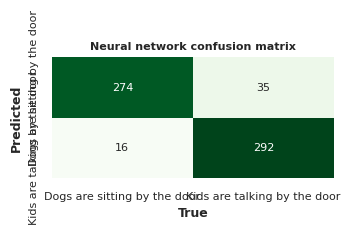

In [40]:
plot_cfm(y_test, y_pred_test, title="Neural network confusion matrix")

In [41]:
net.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                11600     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 16,802
Trainable params: 16,802
Non-trainable params: 0
_________________________________________________________________


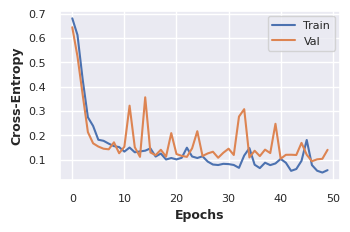

In [42]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

29/29 [==============================] - 0s 2ms/step


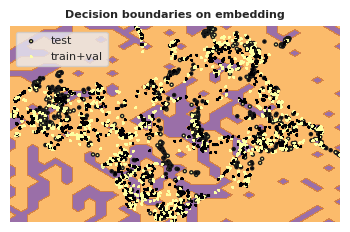

In [43]:
boundaries_on_embedding(reducer, net, embedding=embedding, 
                        n_pts=30,
                       cmap="inferno",
                       titile="Neural network on PCA")

# Ensemble methods

## Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [45]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 15:30:00,669] A new study created in memory with name: no-name-7752a621-87bb-4ff1-82cd-364b23ebc0ce
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-08 15:30:15,948] Trial 1 finished with value: 0.9586776859504132 and parameters: {'n_estimators': 230, 'max_depth': 60, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9586776859504132.
[I 2023-07-08 15:30:26,582] Trial 3 finished with value: 0.9559228650137741 and parameters: {'n_estimators': 650, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-08 15:32:24,360] Trial 12 finished with value: 0.9586776859504132 and parameters: {'n_estimators': 790, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9586776859504132.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the

[W 2023-07-08 15:33:06,569] Trial 24 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-07-08 15:33:37,557] Trial 18 finished with value: 0.953168044077135 and parameters: {'n_estimators': 1260, 'max_depth': 100, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9586776859504132.
[W 2023-07-08 15:33:37,619] Trial 26 failed with parameters: {'n_estimators': 220, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: Inval

[W 2023-07-08 15:33:42,942] Trial 31 failed with value None.
[W 2023-07-08 15:33:43,011] Trial 32 failed with parameters: {'n_estimators': 1680, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 6, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-08 15:33:43,369] Trial 37 failed with value None.
[W 2023-07-08 15:33:43,439] Trial 38 failed with parameters: {'n_estimators': 200, 'max_depth': 50, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 6, 'bootstrap': True, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualen

[W 2023-07-08 15:33:43,802] Trial 43 failed with value None.
[W 2023-07-08 15:33:43,868] Trial 44 failed with parameters: {'n_estimators': 1700, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 1, 'min_samples_leaf': 6, 'bootstrap': False, 'criterion': 'entropy'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-08 15:33:44,215] Trial 49 failed with value None.
[I 2023-07-08 15:34:03,779] Trial 25 finished with value: 0.9559228650137741 and parameters: {'n_estimators': 1220, 'max_depth': 100, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9586776859504132.
[I 2023-07-08 15:34:06,073] Trial 22 finished with value: 0.9559228650137741 and parameters: {'n_estimators': 1290, 'max_depth': 100, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9586776859504132.
[I 2023-07-08 15:34:22,820] Trial 28 finished with value: 0.9559228650137741 and parameters: {'n_estimators': 1170, 'max_depth': 50, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9586776859504132.


In [46]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 230, 'max_depth': 60, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       309
           1       0.90      0.92      0.91       308

    accuracy                           0.91       617
   macro avg       0.91      0.91      0.91       617
weighted avg       0.91      0.91      0.91       617

Accuracy 0.9092382495948136
F1-score [0.90879479 0.90967742]


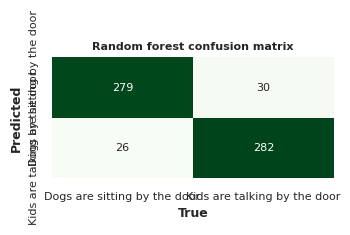

In [47]:
plot_cfm(y_test, y_pred_test, title="Random forest confusion matrix")

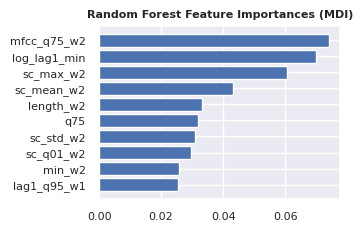

In [48]:
nbr_features = X_train.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

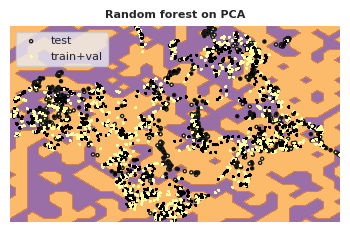

In [49]:
boundaries_on_embedding(reducer, rf, embedding=embedding,
                       cmap="inferno",
                       n_pts=30,
                        title="Random forest on PCA")

In [50]:
from sklearn.inspection import permutation_importance

In [51]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

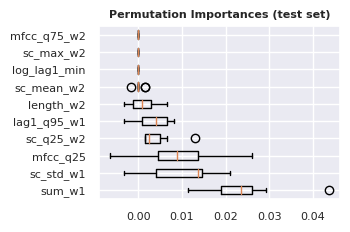

In [52]:
sorted_idx = result.importances_mean.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [53]:
from sklearn.tree import plot_tree

In [54]:
rf.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_depth=60, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=7,
                       random_state=582153120)

In [ ]:
plt.figure(figsize=(6,6))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

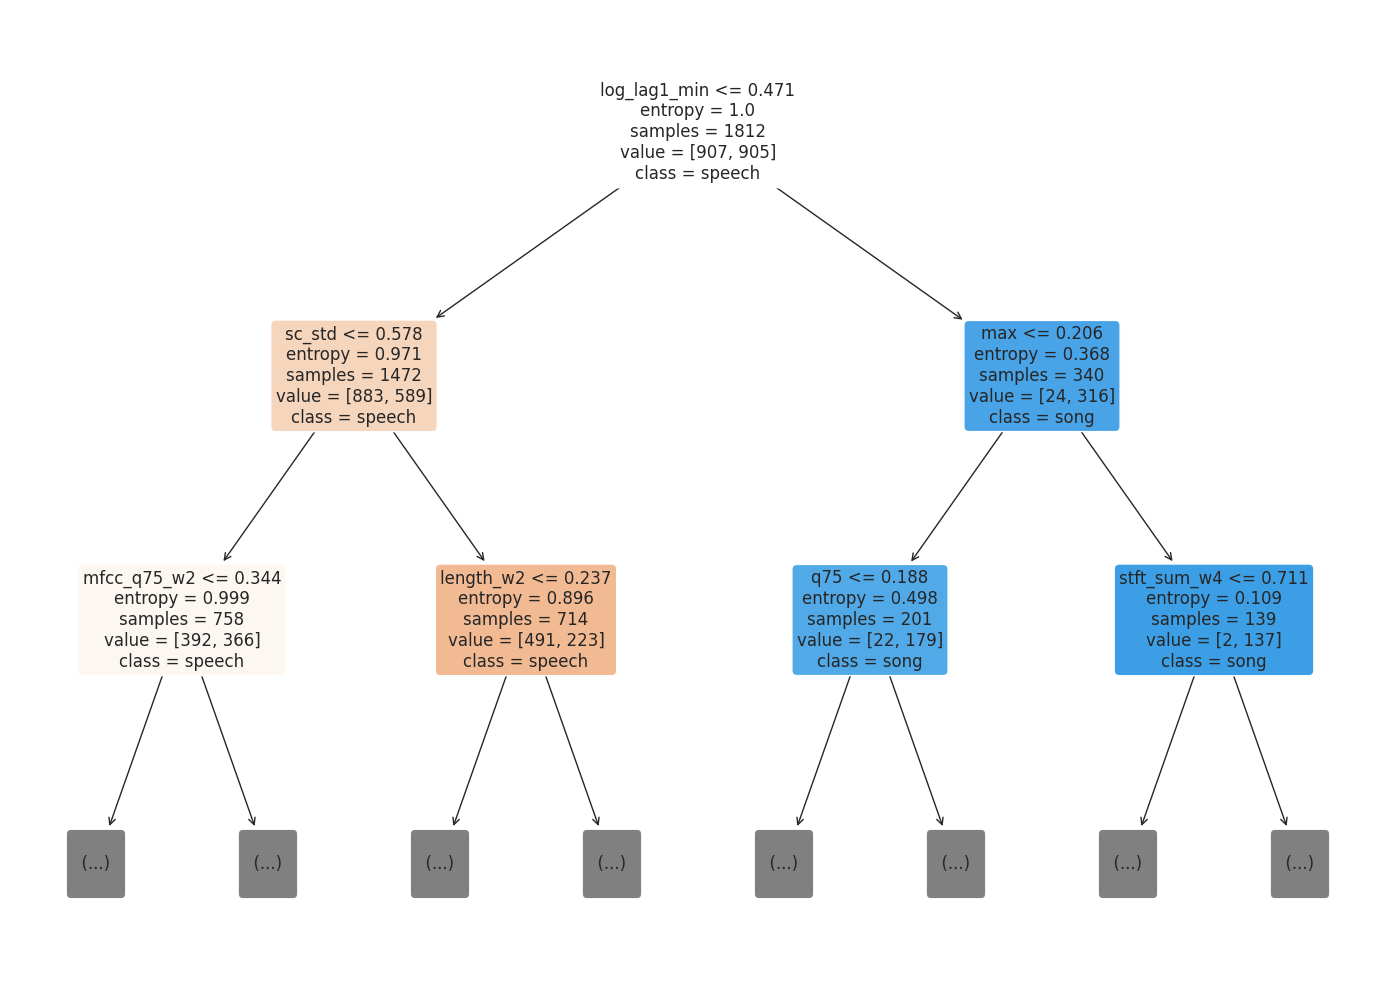

In [56]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [57]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [58]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

[I 2023-07-08 15:37:06,461] A new study created in memory with name: no-name-f8313081-7fbb-4389-b389-6d467c582714
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[W 2023-07-08 15:37:06,494] Trial 2 failed with parameters: {'n_estimators': 1, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 9, 'learning_rate': 0.04759393411373759, 'criterion': 'mae', 'subsample': 0.9905901712216874, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/

[W 2023-07-08 15:37:07,869] Trial 11 failed with parameters: {'n_estimators': 18, 'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 10, 'learning_rate': 0.12856520569627752, 'criterion': 'friedman_mse', 'subsample': 0.8980586238352251, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'min_samples_split' parameter of GradientBoostingClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local

[W 2023-07-08 15:37:08,376] Trial 17 failed with value None.
[I 2023-07-08 15:37:08,751] Trial 6 finished with value: 1.0 and parameters: {'n_estimators': 18, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 8, 'learning_rate': 0.10569359267079786, 'criterion': 'friedman_mse', 'subsample': 0.6936192365224629, 'loss': 'exponential'}. Best is trial 3 with value: 1.0.
[W 2023-07-08 15:37:08,763] Trial 19 failed with parameters: {'n_estimators': 8, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 9, 'learning_rate': 0.1235806503515604, 'criterion': 'mae', 'subsample': 0.9546104968797688, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optu

[W 2023-07-08 15:37:09,510] Trial 26 failed with value None.
[W 2023-07-08 15:37:09,585] Trial 27 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 3, 'learning_rate': 0.017252518992074695, 'criterion': 'mae', 'subsample': 0.5107637329203266, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-08 15:37:09,983] Trial 32 failed with value None.
[W 2023-07-08 15:37:10,059] Trial 33 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 3, 'learning_rate': 0.29976934257417814, 'criterion': 'mae', 'subsample': 0.5268724716510589, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-08 15:37:10,457] Trial 38 failed with value None.
[W 2023-07-08 15:37:10,530] Trial 39 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 3, 'learning_rate': 0.017007269070556524, 'criterion': 'mae', 'subsample': 0.5220332277326085, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-08 15:37:10,928] Trial 44 failed with value None.
[W 2023-07-08 15:37:11,006] Trial 45 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 3, 'learning_rate': 0.014502967608426176, 'criterion': 'mae', 'subsample': 0.5057385059914583, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-08 15:37:11,403] Trial 50 failed with value None.
[W 2023-07-08 15:37:11,485] Trial 51 failed with parameters: {'n_estimators': 12, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 3, 'learning_rate': 0.02361212663696141, 'criterion': 'mae', 'subsample': 0.5067016939566411, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-08 15:37:11,883] Trial 56 failed with value None.
[W 2023-07-08 15:37:11,959] Trial 57 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 3, 'learning_rate': 0.024996918958308828, 'criterion': 'mae', 'subsample': 0.5313061309312848, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-08 15:37:12,375] Trial 62 failed with value None.
[W 2023-07-08 15:37:12,452] Trial 63 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 3, 'learning_rate': 0.015541994331890518, 'criterion': 'mae', 'subsample': 0.5094790847561312, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-08 15:37:12,845] Trial 68 failed with value None.
[W 2023-07-08 15:37:12,925] Trial 69 failed with parameters: {'n_estimators': 5, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 3, 'learning_rate': 0.020095696196004653, 'criterion': 'mae', 'subsample': 0.5361949620250565, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-08 15:37:13,379] Trial 74 failed with parameters: {'n_estimators': 6, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 3, 'learning_rate': 0.2970686440706328, 'criterion': 'mae', 'subsample': 0.5320732167999738, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/l

[W 2023-07-08 15:37:13,695] Trial 78 failed with value None.
[W 2023-07-08 15:37:13,705] Trial 79 failed with value None.
[W 2023-07-08 15:37:13,808] Trial 80 failed with parameters: {'n_estimators': 7, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 3, 'learning_rate': 0.29173923147319547, 'criterion': 'mae', 'subsample': 0.8046432731910517, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/

[W 2023-07-08 15:37:14,196] Trial 85 failed with value None.
[W 2023-07-08 15:37:14,304] Trial 86 failed with parameters: {'n_estimators': 6, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 3, 'learning_rate': 0.2837614763910953, 'criterion': 'mae', 'subsample': 0.5114098975007828, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-08 15:37:14,644] Trial 90 failed with value None.
[W 2023-07-08 15:37:14,656] Trial 91 failed with value None.
[W 2023-07-08 15:37:14,767] Trial 92 failed with parameters: {'n_estimators': 7, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 3, 'learning_rate': 0.28119422347926326, 'criterion': 'mae', 'subsample': 0.537789822959642, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/e

[W 2023-07-08 15:37:15,106] Trial 97 failed with value None.
[W 2023-07-08 15:37:15,115] Trial 96 failed with value None.
[W 2023-07-08 15:37:15,262] Trial 99 failed with parameters: {'n_estimators': 7, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 3, 'learning_rate': 0.2989334146956993, 'criterion': 'mae', 'subsample': 0.8061028195786323, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_122476/2811804968.py", line 17, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/e

In [59]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


{'n_estimators': 11, 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.11134307248679587, 'criterion': 'friedman_mse', 'subsample': 0.9447631859254138, 'loss': 'deviance'}
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       309
           1       0.85      0.90      0.87       308

    accuracy                           0.87       617
   macro avg       0.87      0.87      0.87       617
weighted avg       0.87      0.87      0.87       617

Accuracy 0.8719611021069692
F1-score [0.86898839 0.8748019 ]


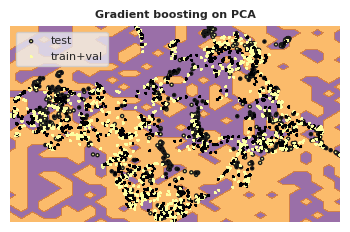

In [60]:
boundaries_on_embedding(reducer, gb, embedding=embedding,
                       cmap="inferno",
                       n_pts=30,
                       title="Gradient boosting on PCA")